## Financial Transaction Reconciliation

### Business Context

**Problem:** Finance teams spend hours each day matching bank transactions with internal ledger records. This is time-consuming, error-prone, and doesn't scale as transaction volumes grow.

**Solution:** Building an automated reconciliation system that:
 1. Matches bank and ledger transactions using realistic rules
 2. Flags discrepancies that need human attention
 3. Produces clear reports for daily operations

**reconciliation process:**

1. **Understanding the Data** – What we're working with
2. **Cleaning & Standardization** – Getting the data match-ready
3. **Feature Engineering** – Creating smart matching features
4. **Reconciliation Logic** – The actual matching rules
5. **Results & Reporting** – Business-ready outputs

### 1. Setup & Data Loading

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from rapidfuzz import fuzz
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setting up visual style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

**Loading two main datasets**

In [27]:
# Bank statement - the external truth from our bank
bank_df = pd.read_csv("../data/raw/bank_statement.csv")
print(f"Bank statement loaded: {len(bank_df)} transactions")

# Ledger transactions - our internal accounting records
ledger_df = pd.read_csv("../data/raw/ledger_transactions.csv")
print(f"Ledger transactions loaded: {len(ledger_df)} transactions")

# Let's peek at the data
print("\nFirst few bank transactions:")
display(bank_df.head(3))

print("\nFirst few ledger transactions:")
display(ledger_df.head(3))

Bank statement loaded: 500 transactions
Ledger transactions loaded: 500 transactions

First few bank transactions:


,transaction_id,date,amount,reference,description,bank_account,transaction_type
0,BANK00250,2024-01-01,418.23,REF984979,Transaction REF984979,BUSINESS_ACCOUNT_001,CREDIT
1,BANK00105,2024-01-01,799.12,REF242045,Transaction REF242045,BUSINESS_ACCOUNT_001,DEBIT
2,BANK00136,2024-01-01,1068.91,CHK356210,Transaction CHK356210,BUSINESS_ACCOUNT_001,DEBIT



First few ledger transactions:


,transaction_id,date,amount,reference,description,bank_account,transaction_type,gl_account,posted_by
0,LEDG00165,2024-01-01,603.77,INV-476627,Transaction INV476627,BUSINESS_ACCOUNT_001,DEBIT,2002,USER_JOHN
1,LEDG00380,2024-01-01,1068.91,CHK356210,Transaction CHK356210,BUSINESS_ACCOUNT_001,DEBIT,2002,SYSTEM_AUTO
2,LEDG00122,2024-01-01,829.56,SAL558783,Transaction SAL558783,BUSINESS_ACCOUNT_001,CREDIT,1002,SYSTEM_AUTO


### 2. Understanding the Data (Exploratory Analysis)

**Basic information about data**

In [28]:
print("Bank Statement Data")
print(f"Date range: {bank_df['date'].min()} to {bank_df['date'].max()}")
print(f"Amount range: ${bank_df['amount'].min():.2f} to ${bank_df['amount'].max():.2f}")
print(f"Total transactions: {len(bank_df):,}")
print(f"Total amount: ${bank_df['amount'].sum():,.2f}")

print("\nLedger Data (Internal Accounting Records)")
print(f"Date range: {ledger_df['date'].min()} to {ledger_df['date'].max()}")
print(f"Amount range: ${ledger_df['amount'].min():.2f} to ${ledger_df['amount'].max():.2f}")
print(f"Total transactions: {len(ledger_df):,}")
print(f"Total amount: ${ledger_df['amount'].sum():,.2f}")

Bank Statement Data
Date range: 2024-01-01 to 2024-03-30
Amount range: $10.47 to $1999.44
Total transactions: 500
Total amount: $399,291.10

Ledger Data (Internal Accounting Records)
Date range: 2024-01-01 to 2024-03-30
Amount range: $10.47 to $1999.44
Total transactions: 500
Total amount: $399,128.08


**Checking for missing values as these can break reconciliation**

In [29]:
print("\nChecking for missing values:")

missing_bank = bank_df.isnull().sum()
missing_ledger = ledger_df.isnull().sum()

print("Missing values in bank statement:")
print(missing_bank[missing_bank > 0])

print("\nMissing values in ledger:")
print(missing_ledger[missing_ledger > 0])


Checking for missing values:
Missing values in bank statement:
Series([], dtype: int64)

Missing values in ledger:
reference    21
dtype: int64


**Visual of transaction volumes Comparison between Bank and Ledger over time**

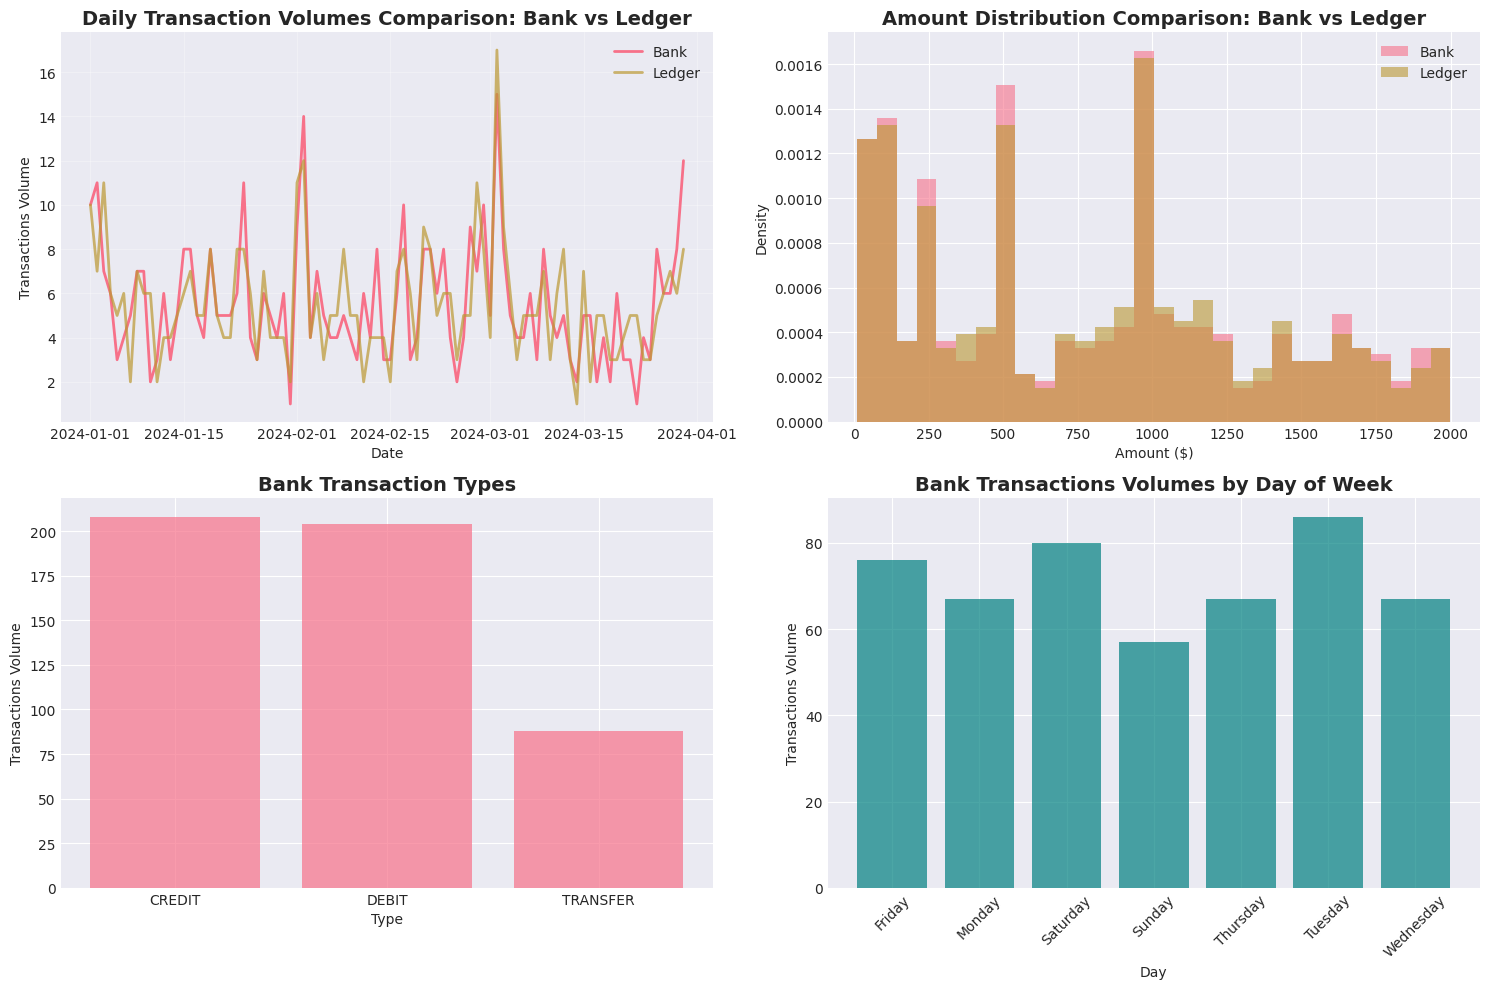

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

bank_df['date'] = pd.to_datetime(bank_df['date'])
ledger_df['date'] = pd.to_datetime(ledger_df['date'])

# Plot 1: Daily transaction volume/ counts
bank_daily = bank_df.groupby(bank_df['date'].dt.date).size().reset_index(name='tx_volume')
ledger_daily = ledger_df.groupby(ledger_df['date'].dt.date).size().reset_index(name='tx_volume')

axes[0, 0].plot(bank_daily['date'], bank_daily['tx_volume'], label='Bank', linewidth=2)
axes[0, 0].plot(ledger_daily['date'], ledger_daily['tx_volume'], label='Ledger', linewidth=2, alpha=0.7)
axes[0, 0].set_title('Daily Transaction Volumes Comparison: Bank vs Ledger', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Transactions Volume')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Transaction amount distribution
axes[0, 1].hist(bank_df['amount'].abs(), bins=30, alpha=0.6, label='Bank', density=True)
axes[0, 1].hist(ledger_df['amount'].abs(), bins=30, alpha=0.6, label='Ledger', density=True)
axes[0, 1].set_title('Amount Distribution Comparison: Bank vs Ledger', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Amount ($)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# Plot 3: Transaction types
bank_types = bank_df['transaction_type'].value_counts().reset_index(name='count')
axes[1, 0].bar(bank_types['transaction_type'], bank_types['count'], alpha=0.7)
axes[1, 0].set_title('Bank Transaction Types', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Type')
axes[1, 0].set_ylabel('Transactions Volume')

# Plot 4: Day of week pattern
bank_df['day_of_week'] = bank_df['date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

bankday_of_week_df = bank_df.groupby('day_of_week').agg(
    tx_volume=('transaction_id', 'count')
).reset_index()
axes[1, 1].bar(bankday_of_week_df['day_of_week'], bankday_of_week_df['tx_volume'], alpha=0.7, color='teal')
axes[1, 1].set_title('Bank Transactions Volumes by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Transactions Volume')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**EDA insights:**

1. We have different transaction volumes in bank vs ledger data, which implies presennce of discrepancies
      - This could be due to: 
        - timing differences (some bank transactions of day x reflecting on day y in the ledger)
        - different transaction volumes for the same days

There fore in the next sections shall be exploring data for patterns as I set the different matching logic rules

### 3. Data Cleaning & Standardization

Cleaning the data for better matching
 - Goal: Make the data as consistent as possible before reconciliation

**Data Cleaning Steps:**
1. Creating copies to preserve original data
2. Fixing dates to ensure they are proper datetime objects
3. Cleaning reference text fields - this is crucial for matching
4. Adding fields for absolute amounts for amount matching (ignoring debit/credit signs for now)

In [31]:
bank_clean = bank_df.copy()
ledger_clean = ledger_df.copy()

bank_clean['date'] = pd.to_datetime(bank_clean['date'])
ledger_clean['date'] = pd.to_datetime(ledger_clean['date'])

bank_clean['amount'] = bank_clean['amount'].astype(float).round(2)
ledger_clean['amount'] = ledger_clean['amount'].astype(float).round(2)

def clean_reference(text):
    if pd.isna(text):
        return ''    
    # Convert to string and lowercase
    text = str(text).lower()    
    # Remove common noise
    text = text.replace('inv-', 'inv')
    text = text.replace('pay-', 'pay')
    text = text.replace('ref-', 'ref')    
    # Remove special characters, keep only letters and numbers
    text = ''.join(char for char in text if char.isalnum())    
    return text

bank_clean['reference_clean'] = bank_clean['reference'].apply(clean_reference)
ledger_clean['reference_clean'] = ledger_clean['reference'].apply(clean_reference)

bank_clean['amount_abs'] = bank_clean['amount'].abs()
ledger_clean['amount_abs'] = ledger_clean['amount'].abs()

print("\nBEFORE cleaning - sample references:")
print("Bank:", bank_df['reference'].iloc[:3].tolist())
print("Ledger:", ledger_df['reference'].iloc[:3].tolist())

print("\nAFTER cleaning - sample references:")
print("Bank:", bank_clean['reference_clean'].iloc[:3].tolist())
print("Ledger:", ledger_clean['reference_clean'].iloc[:3].tolist())

# Save cleaned data
bank_clean.to_csv("../data/processed/cleaned_bank.csv", index=False)
ledger_clean.to_csv("../data/processed/cleaned_ledger.csv", index=False)


BEFORE cleaning - sample references:
Bank: ['REF984979', 'REF242045', 'CHK356210']
Ledger: ['INV-476627', 'CHK356210', 'SAL558783']

AFTER cleaning - sample references:
Bank: ['ref984979', 'ref242045', 'chk356210']
Ledger: ['inv476627', 'chk356210', 'sal558783']


### 4. Feature Engineering

Creating smart features for better matching
 - These features will help us match transactions even when they are not identical

**Creating potential match pairs**
 - Each bank transaction paired with each ledger transaction
 - Since we had 500 bank_df records vs 500 ledger_df records 
     - then potential match pairs shall be: 
        - (500 * 500) = 250,000 records 

In [32]:
# Adding a key field for merging
bank_clean['key'] = 1
ledger_clean['key'] = 1

# Creating all possible combinations
match_candidates = bank_clean.merge(
    ledger_clean, 
    on='key', 
    suffixes=('_bank', '_ledger') # for shared column names adding suffix
).drop('key', axis=1)

print(f"Created {len(match_candidates):,} potential match pairs")

print("\nSample match candidates df:")
match_candidates.head(3)

Created 250,000 potential match pairs

Sample match candidates df:


,transaction_id_bank,date_bank,amount_bank,reference_bank,description_bank,bank_account_bank,transaction_type_bank,day_of_week,reference_clean_bank,amount_abs_bank,...,date_ledger,amount_ledger,reference_ledger,description_ledger,bank_account_ledger,transaction_type_ledger,gl_account,posted_by,reference_clean_ledger,amount_abs_ledger
0,BANK00250,2024-01-01,418.23,REF984979,Transaction REF984979,BUSINESS_ACCOUNT_001,CREDIT,Monday,ref984979,418.23,...,2024-01-01,603.77,INV-476627,Transaction INV476627,BUSINESS_ACCOUNT_001,DEBIT,2002,USER_JOHN,inv476627,603.77
1,BANK00250,2024-01-01,418.23,REF984979,Transaction REF984979,BUSINESS_ACCOUNT_001,CREDIT,Monday,ref984979,418.23,...,2024-01-01,1068.91,CHK356210,Transaction CHK356210,BUSINESS_ACCOUNT_001,DEBIT,2002,SYSTEM_AUTO,chk356210,1068.91
2,BANK00250,2024-01-01,418.23,REF984979,Transaction REF984979,BUSINESS_ACCOUNT_001,CREDIT,Monday,ref984979,418.23,...,2024-01-01,829.56,SAL558783,Transaction SAL558783,BUSINESS_ACCOUNT_001,CREDIT,1002,SYSTEM_AUTO,sal558783,829.56


**Creating the Features:**  
- These feature shall be used to build a Match Confidence Score (0-100)

In [33]:
#Feature 1: Amount difference
match_candidates['amount_diff'] = abs(match_candidates['amount_abs_bank'] - match_candidates['amount_abs_ledger'])

# Feature 2: Date difference (in days)
match_candidates['date_diff_days'] = abs((match_candidates['date_bank'] - match_candidates['date_ledger']).dt.days)

# Feature 3: Reference similarity
"""
calculating fuzzy similarity between two values, returning 0 if either value is empty or missing
"""
def calculate_similarity(val1, val2):
    str1 = str(val1).strip() if val1 else ""
    str2 = str(val2).strip() if val2 else ""    
    if not str1 or not str2:
        return 0    
    return fuzz.partial_ratio(str1, str2)

# Applying the similarity calculation to each row
match_candidates['reference_similarity'] = match_candidates.apply(
    lambda row: calculate_similarity(row['reference_clean_bank'], row['reference_clean_ledger']),
    axis=1
)

# Feature 4: Flagging exact amount matches
match_candidates['exact_amount_match'] = (match_candidates['amount_diff'] == 0)

# Feature 5: Flag same-day transactions
match_candidates['same_day'] = (
    match_candidates['date_diff_days'] == 0
)

**Match confidence score** 
 - Since we matching transactions from two different sources, we shall be auditing both thus cannot rely on just one source as the source of truth.
    - therefore we shall combine the feature scores for the fields calculated in comparison of the two data sources to come up with one confidence score.

 - The final score ranges from 0 to 100 with: 
    - Higher score indicative of more confident it’s a true match
    - Lower score likely not the same transaction

The match confidence score shall be comprised of: 
1. Reference similarity (40%)
    - checks how similar the text descriptions are (transaction references).
        - If the text looks very similar: high score
    - This shall be my most important clue, so it gets a weight of 40% of the total score

2. Amount closeness (30%)
    - checks how close the transaction amounts are.
         - Same amount: full score (based on scale of 0-100)
         - Small difference: partial score
         - Difference of 100 or more: no score
    - This allows for small rounding or processing differences reducing positives negatives

3. Date closeness (30%)
    - checks how close the transaction dates are.
        - Same day: full score
        - A few days apart: partial score
        - More than 7 days apart: no score
    - Here basing on the assuption that Matching transactions usually happen around the same time.

In [34]:
# weights
REF_WEIGHT = 0.4
AMOUNT_WEIGHT = 0.3
DATE_WEIGHT = 0.3

# Amount score: 0–100 based on closeness
match_candidates['amount_score'] = 100 * (1 - np.minimum(1, match_candidates['amount_diff'] / 100))
# Date score: 0–100 based on closeness
match_candidates['date_score']   = 100 * (1 - np.minimum(1, match_candidates['date_diff_days'] / 7))

# Final confidence score
match_candidates['match_confidence'] = (
    match_candidates['reference_similarity'] * REF_WEIGHT +
    match_candidates['amount_score'] * AMOUNT_WEIGHT +
    match_candidates['date_score'] * DATE_WEIGHT
)

feature_sample = match_candidates[['transaction_id_bank', 'transaction_id_ledger', 'amount_diff', 
                                   'date_diff_days', 'reference_similarity', 'amount_score', 
                                   'date_score', 'match_confidence']]
print("\nSample of engineered features:")

display(feature_sample.head())

print("\nFeature stats:")
print(f"Average amount difference: ${match_candidates['amount_diff'].mean():.2f}")
print(f"Average date difference: {match_candidates['date_diff_days'].mean():.1f} days")
print(f"Average reference similarity: {match_candidates['reference_similarity'].mean():.0f}/100")


Sample of engineered features:


,transaction_id_bank,transaction_id_ledger,amount_diff,date_diff_days,reference_similarity,amount_score,date_score,match_confidence
0,BANK00250,LEDG00165,185.54,0,30.769231,0.0,100.0,42.307692
1,BANK00250,LEDG00380,650.68,0,0.000000,0.0,100.0,30.000000
2,BANK00250,LEDG00122,411.33,0,30.769231,0.0,100.0,42.307692
3,BANK00250,LEDG00434,368.23,0,42.857143,0.0,100.0,47.142857
4,BANK00250,LEDG00095,331.72,0,33.333333,0.0,100.0,43.333333



Feature stats:
Average amount difference: $646.19
Average date difference: 30.0 days
Average reference similarity: 35/100


### 5. Reconciliation Logic

We shall match transactions from the bank and the ledger, categorize the matches by confidence, and flag anything that doesn’t match for review

**Defining Transactions rules/ catergories:** 
1. `Exact matches` – Perfectly alignment across all three signals (amount, date, reference). 
    - Highest confidence.
2. `Tolerance matches` – Close enough according to business-defined rules (small differences in amount or date, slightly different references). 
    - Medium confidence.
3. `Fuzzy matches` – Matches that are not perfect but have high overall confidence based on the weighted match score. 
    - Lower confidence, flagged for review.
4. `Exceptions` – Transactions that didn’t match at all. 
    - These require investigation.

**RULE 1: EXACT MATCHES**
 - Goal: Find transactions that are essentially identical.
 - Rules:
    - `Amount difference` = 0 implying amounts match exactly
    - `Date difference` = 0 implying same day
    - `Reference similarity` ≥ 95 implying almost identical text
- Catergory: 
    - Priority: 1 = highest
    - These are our most trusted matches.

In [35]:
exact_matches = match_candidates[
    (match_candidates['amount_diff'] == 0) &           # Same amount
    (match_candidates['date_diff_days'] == 0) &        # Same date
    (match_candidates['reference_similarity'] >= 95)   # Almost identical reference
].copy()

exact_matches['match_type'] = 'Exact Match'
exact_matches['match_priority'] = 1  # Highest priority

print(f"Found {len(exact_matches):,} exact matches")

Found 258 exact matches


**RULE 2: TOLERANCE MATCHES**
 - Goal: Catch transactions that are not perfect but still likely matches.
 - Rules:
   - `Amount` within $2
   - `Date` within 3 days
   - `Reference similarity` ≥ 70
- Catergory: 
   - Priority: 2 = medium confidence
   - these are close enough for automated matching, but slightly less certain.

In [36]:
# transactions that have not been matched yet. 
remaining_candidates = match_candidates[
    ~match_candidates['transaction_id_bank'].isin(exact_matches['transaction_id_bank']) &
    ~match_candidates['transaction_id_ledger'].isin(exact_matches['transaction_id_ledger'])
]

# Tolerance rules (business rules we define)
tolerance_matches = remaining_candidates[
    (remaining_candidates['amount_diff'] <= 2.00) &          # Amount within $2
    (remaining_candidates['date_diff_days'] <= 3) &          # Date within 3 days
    (remaining_candidates['reference_similarity'] >= 70)     # Reference somewhat similar
].copy()

tolerance_matches['match_type'] = 'Tolerance Match'
tolerance_matches['match_priority'] = 2  # Medium priority

print(f"Found {len(tolerance_matches):,} tolerance matches")

Found 179 tolerance matches


**RULE 3: FUZZY MATCHES**
 - Goal: Aggressively match transactions using the overall confidence score.
 - Rule: 
    - `match_confidence` ≥ 80
- Catergory: 
    - Priority: 3 = lower confidence, flagged for review
    - These are matches that might need human oversight.

In [37]:
remaining_after_tolerance = remaining_candidates[
    ~remaining_candidates['transaction_id_bank'].isin(tolerance_matches['transaction_id_bank']) &
    ~remaining_candidates['transaction_id_ledger'].isin(tolerance_matches['transaction_id_ledger'])
]

# Fuzzy matching based on confidence score
fuzzy_matches = remaining_after_tolerance[
    (remaining_after_tolerance['match_confidence'] >= 80)  # High overall confidence
].copy()

fuzzy_matches['match_type'] = 'Fuzzy Match'
fuzzy_matches['match_priority'] = 3  # Lower priority, needs review

print(f"Found {len(fuzzy_matches):,} fuzzy matches")

Found 0 fuzzy matches


**COMBINING ALL MATCHES**
 - Combining all types of matches into one dataset
 - Sort by priority so exact matches are favored if a transaction appears in multiple match types
 - Then Remove duplicates so that each transaction is matched at most once

In [38]:
all_matches = pd.concat([
    exact_matches,
    tolerance_matches,
    fuzzy_matches
], ignore_index=True)

# Remove duplicates i.e if a transaction matched multiple ways, keep best match
all_matches = all_matches.sort_values('match_priority').drop_duplicates(
    subset=['transaction_id_bank', 'transaction_id_ledger'],
    keep='first'
)

print(f"Total unique matches found: {len(all_matches):,}")

Total unique matches found: 437


**IDENTIFYING EXCEPTIONS (Unmatched Transactions)**
 - Goal: Flag anything that did not get matched
 - Bank unmatched transactions = high priority (critical)
 - Ledger unmatched = medium priority (often adjustments or timing differences)

These are the exceptions for investigation.

In [39]:
# Bank transactions that didn't match
unmatched_bank = bank_clean[
    ~bank_clean['transaction_id'].isin(all_matches['transaction_id_bank'])
].copy()

unmatched_bank['exception_type'] = 'Bank Transaction Unmatched'
unmatched_bank['priority'] = 'High'  # Bank transactions are usually critical

# Ledger transactions that didn't match
unmatched_ledger = ledger_clean[
    ~ledger_clean['transaction_id'].isin(all_matches['transaction_id_ledger'])
].copy()

unmatched_ledger['exception_type'] = 'Ledger Transaction Unmatched'
unmatched_ledger['priority'] = 'Medium'  # Might be accruals or adjustments

print(f"Unmatched bank transactions: {len(unmatched_bank):,}")
print(f"Unmatched ledger transactions: {len(unmatched_ledger):,}")

# Save matched transactions
all_matches.to_csv("../data/processed/reconciliation_matches.csv", index=False)

# Save exceptions
exceptions = pd.concat([unmatched_bank, unmatched_ledger], ignore_index=True)
exceptions.to_csv("../data/processed/reconciliation_exceptions.csv", index=False)

Unmatched bank transactions: 68
Unmatched ledger transactions: 71


### 6. Results Analysis & Business Reporting

In [40]:
# Calculate key reconciliation metrics
total_bank_transactions = len(bank_clean)
total_ledger_transactions = len(ledger_clean)

matched_bank_transactions = all_matches['transaction_id_bank'].nunique()
matched_ledger_transactions = all_matches['transaction_id_ledger'].nunique()

reconciliation_rate_bank = (matched_bank_transactions / total_bank_transactions) * 100
reconciliation_rate_ledger = (matched_ledger_transactions / total_ledger_transactions) * 100

# summary DF
summary_data = {
    'Metric': [
        'Total Bank Transactions',
        'Total Ledger Transactions',
        'Matched Bank Transactions',
        'Matched Ledger Transactions',
        'Bank Reconciliation Rate',
        'Ledger Reconciliation Rate',
        'Unmatched Bank Transactions',
        'Unmatched Ledger Transactions',
        'Exact Matches',
        'Tolerance Matches',
        'Fuzzy Matches'
    ],
    'Value': [
        f"{total_bank_transactions:,}",
        f"{total_ledger_transactions:,}",
        f"{matched_bank_transactions:,}",
        f"{matched_ledger_transactions:,}",
        f"{reconciliation_rate_bank:.1f}%",
        f"{reconciliation_rate_ledger:.1f}%",
        f"{len(unmatched_bank):,}",
        f"{len(unmatched_ledger):,}",
        f"{len(exact_matches):,}",
        f"{len(tolerance_matches):,}",
        f"{len(fuzzy_matches):,}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\nRECONCILIATION SUMMARY")
display(summary_df)


RECONCILIATION SUMMARY


,Metric,Value
0,Total Bank Transactions,500
1,Total Ledger Transactions,500
2,Matched Bank Transactions,432
3,Matched Ledger Transactions,429
4,Bank Reconciliation Rate,86.4%
5,Ledger Reconciliation Rate,85.8%
6,Unmatched Bank Transactions,68
7,Unmatched Ledger Transactions,71
8,Exact Matches,258
9,Tolerance Matches,179


**Visualize the results**

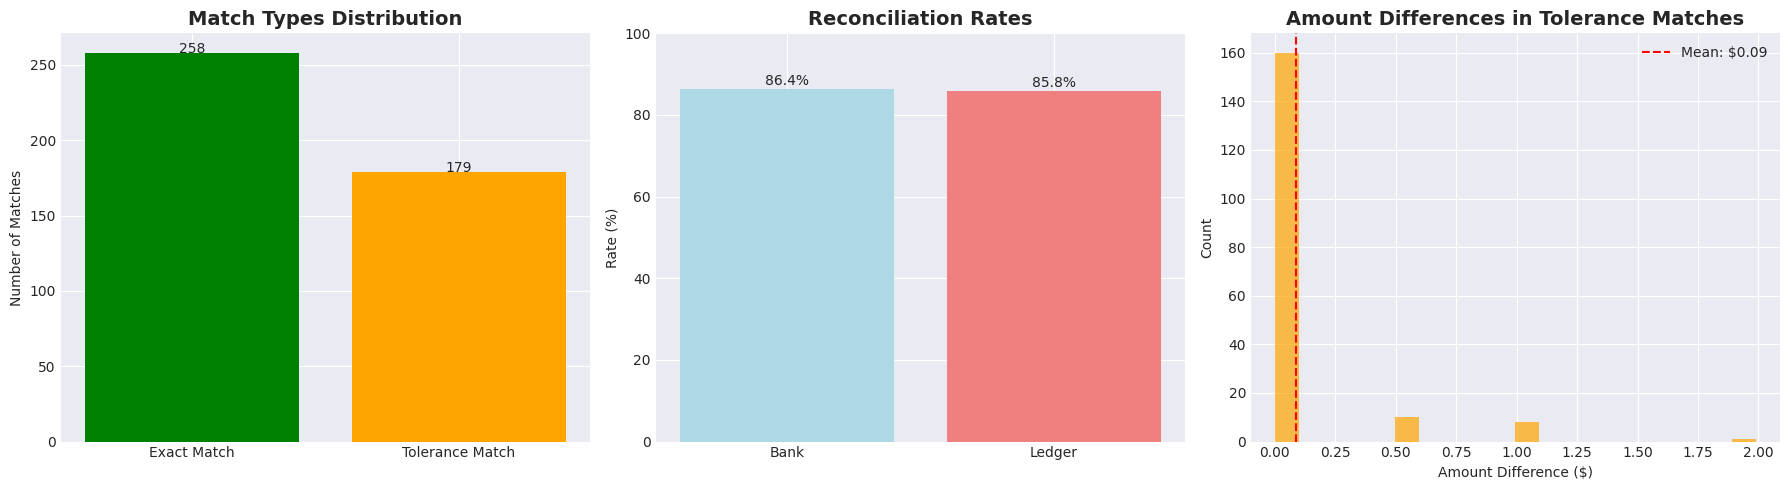

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Match types
match_counts = all_matches['match_type'].value_counts()
axes[0].bar(match_counts.index, match_counts.values, color=['green', 'orange', 'blue'])
axes[0].set_title('Match Types Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Matches')
for i, v in enumerate(match_counts.values):
    axes[0].text(i, v + 0.1, str(v), ha='center')

# Plot 2: Reconciliation rates
rates = [reconciliation_rate_bank, reconciliation_rate_ledger]
labels = ['Bank', 'Ledger']
colors = ['lightblue', 'lightcoral']
axes[1].bar(labels, rates, color=colors)
axes[1].set_title('Reconciliation Rates', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Rate (%)')
axes[1].set_ylim(0, 100)
for i, v in enumerate(rates):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center')

# Plot 3: Amount differences in tolerance matches
if len(tolerance_matches) > 0:
    axes[2].hist(tolerance_matches['amount_diff'], bins=20, alpha=0.7, color='orange')
    axes[2].axvline(tolerance_matches['amount_diff'].mean(), color='red', 
                   linestyle='--', label=f'Mean: ${tolerance_matches["amount_diff"].mean():.2f}')
    axes[2].set_title('Amount Differences in Tolerance Matches', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Amount Difference ($)')
    axes[2].set_ylabel('Count')
    axes[2].legend()
else:
    axes[2].text(0.5, 0.5, 'No tolerance matches', ha='center', va='center', fontsize=12)
    axes[2].set_title('💰 Amount Differences', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

**Analyzing exceptions (unmatched transactions)**

In [42]:
# sample of exceptions
print("\nSAMPLE OF EXCEPTIONS (First 5):")
exception_sample = exceptions[[
    'transaction_id', 'date', 'amount', 'reference', 'exception_type', 'priority'
]].head(5)
display(exception_sample)
    
# Analyze by exception type
print("\nException Breakdown:")
exception_summary = exceptions['exception_type'].value_counts()
for exc_type, count in exception_summary.items():
    print(f"  • {exc_type}: {count:,} transactions")
    
# Analyze by priority
if 'priority' in exceptions.columns:
    print("\nPriority Breakdown:")
    priority_summary = exceptions['priority'].value_counts()
    for priority, count in priority_summary.items():
        print(f"  • {priority} priority: {count:,} transactions")
else:
    print("No exceptions found! Perfect reconciliation")


SAMPLE OF EXCEPTIONS (First 5):


,transaction_id,date,amount,reference,exception_type,priority
0,BANK00015,2024-01-02,484.09,TRF931083,Bank Transaction Unmatched,High
1,BANK00055,2024-01-02,50.00,CHK617275,Bank Transaction Unmatched,High
2,BANK00150,2024-01-04,500.00,REF414360,Bank Transaction Unmatched,High
3,BANK00258,2024-01-07,500.00,SAL621387,Bank Transaction Unmatched,High
4,BANK00302,2024-01-07,843.35,CHK990439,Bank Transaction Unmatched,High



Exception Breakdown:
  • Ledger Transaction Unmatched: 71 transactions
  • Bank Transaction Unmatched: 68 transactions

Priority Breakdown:
  • Medium priority: 71 transactions
  • High priority: 68 transactions


### 7. Conclusion & Next Steps

In [43]:
print("\nBUSINESS SUMMARY")

print(f"\nDate Range: {bank_df['date'].min().date()} to {bank_df['date'].max().date()}")
print(f"Total Value Processed: ${bank_df['amount'].sum():,.2f}")

print(f"\nRECONCILIATION SUCCESS:")
print(f"   • Bank transactions matched: {matched_bank_transactions:,} of {total_bank_transactions:,} ({reconciliation_rate_bank:.1f}%)")
print(f"   • Ledger transactions matched: {matched_ledger_transactions:,} of {total_ledger_transactions:,} ({reconciliation_rate_ledger:.1f}%)")

print(f"\nEXCEPTIONS REQUIRING ATTENTION:")
print(f"   • Unmatched bank transactions: {len(unmatched_bank):,}")
print(f"   • Unmatched ledger transactions: {len(unmatched_ledger):,}")
print(f"   • Total exceptions: {len(exceptions):,}")

print(f"\nMATCH QUALITY:")
print(f"   • Exact matches: {len(exact_matches):,}")
print(f"   • Tolerance matches: {len(tolerance_matches):,}")
if len(fuzzy_matches) > 0:
    print(f"   • Fuzzy matches (needs review): {len(fuzzy_matches):,}")

# Saving KPI summary
kpi_report = pd.DataFrame({
    'KPI': ['Bank Reconciliation Rate', 'Ledger Reconciliation Rate', 
            'Total Exceptions', 'Exact Matches', 'Tolerance Matches'],
    'Value': [f"{reconciliation_rate_bank:.1f}%", f"{reconciliation_rate_ledger:.1f}%",
              f"{len(exceptions):,}", f"{len(exact_matches):,}", f"{len(tolerance_matches):,}"],
    'Target': ['>95%', '>95%', '<5%', 'As high as possible', 'As needed']
})
kpi_report.to_csv("../outputs/kpi_summary.csv", index=False)

# Save action items for operations team
if len(exceptions) > 0:
    action_items = exceptions[['transaction_id', 'date', 'amount', 
                               'reference', 'exception_type', 'priority']].copy()
    action_items['action_required'] = 'Investigate discrepancy'
    action_items['assigned_to'] = 'Reconciliation Team'
    action_items['due_date'] = pd.to_datetime('today') + pd.Timedelta(days=2)
    
    action_items.to_csv("../outputs/action_items.csv", index=False)

# Save match details for audit trail
match_details = all_matches[[
    'transaction_id_bank', 'transaction_id_ledger',
    'date_bank', 'date_ledger',
    'amount_bank', 'amount_ledger',
    'reference_bank', 'reference_ledger',
    'match_type', 'match_confidence'
]].copy()

match_details.to_csv("../outputs/match_details.csv", index=False)


BUSINESS SUMMARY

Date Range: 2024-01-01 to 2024-03-30
Total Value Processed: $399,291.10

RECONCILIATION SUCCESS:
   • Bank transactions matched: 432 of 500 (86.4%)
   • Ledger transactions matched: 429 of 500 (85.8%)

EXCEPTIONS REQUIRING ATTENTION:
   • Unmatched bank transactions: 68
   • Unmatched ledger transactions: 71
   • Total exceptions: 139

MATCH QUALITY:
   • Exact matches: 258
   • Tolerance matches: 179


**Note**: Reconciliation is an iterative process.
 - The goal is not 100% automation, but maximizing efficiency while ensuring financial accuracy.